In [1]:
import pandas as pd
import requests
import os
import io
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path_download_zip_data = 'https://archive.ics.uci.edu/static/public/851/steel+industry+energy+consumption.zip'
path_raw_download = r"../data/0_raw"

In [3]:
response = requests.get(path_download_zip_data)

In [4]:
if response.status_code == 200:
    zip_file = io.BytesIO(response.content)

    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(path_raw_download)

In [5]:
data = pd.read_csv(os.path.join(path_raw_download, 'Steel_industry_data.csv'))
print(data.shape)
data.head()

(35040, 11)


,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


In [6]:
data.dtypes

date                                     object
Usage_kWh                               float64
Lagging_Current_Reactive.Power_kVarh    float64
Leading_Current_Reactive_Power_kVarh    float64
CO2(tCO2)                               float64
Lagging_Current_Power_Factor            float64
Leading_Current_Power_Factor            float64
NSM                                       int64
WeekStatus                               object
Day_of_week                              object
Load_Type                                object
dtype: object

In [7]:
dict(data.dtypes).values()

dict_values([dtype('O'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('int64'), dtype('O'), dtype('O'), dtype('O')])

In [8]:
data_types = {'date',
              'Usage_kWh',
              'Lagging_Current_Reactive.Power_kVarh',
              'Leading_Current_Reactive_Power_kVarh',
              'CO2(tCO2)',
              'Lagging_Current_Power_Factor',
              'Leading_Current_Power_Factor',
              'NSM',
              'WeekStatus',
              'Day_of_week',
              'Load_Type',
              'hours',
              'week_day_coded',
              'day_week_encoder',
              'loadtype_encoder'
            }

In [9]:
data.isna().sum()

date                                    0
Usage_kWh                               0
Lagging_Current_Reactive.Power_kVarh    0
Leading_Current_Reactive_Power_kVarh    0
CO2(tCO2)                               0
Lagging_Current_Power_Factor            0
Leading_Current_Power_Factor            0
NSM                                     0
WeekStatus                              0
Day_of_week                             0
Load_Type                               0
dtype: int64

In [10]:
data.WeekStatus.unique()

array(['Weekday', 'Weekend'], dtype=object)

In [11]:
data.Day_of_week.unique()

array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
       'Sunday'], dtype=object)

In [12]:
data.Load_Type.unique()

array(['Light_Load', 'Medium_Load', 'Maximum_Load'], dtype=object)

# Feature Engineering

Primero vamos a asignar los valores categoricos a una variable numérica debido a su baja dimensionalidad y además asignar un orden a las categorias

In [13]:
week_day_encoder = {'Weekday': 0,
                    'Weekend': 1}
day_week_encoder = {'Monday': 0,
                    'Tuesday': 1,
                    'Wednesday': 2,
                    'Thursday': 3,
                    'Friday': 4,
                    'Saturday': 5,
                    'Sunday': 6}
load_type_encoder = {'Light_Load': 0 ,
                     'Medium_Load': 1,
                     'Maximum_Load': 2}

In [14]:
data['week_day_coded'] = data.WeekStatus.map(week_day_encoder)
data['day_week_encoder'] = data.Day_of_week.map(day_week_encoder)
data['loadtype_encoder'] = data.Load_Type.map(load_type_encoder)

Asignamos los formatos correctos de fechas

In [15]:
data.date = pd.to_datetime(data.date, format="%d/%m/%Y %H:%M")

In [16]:
data['hours'] = data['date'].dt.hour

# Visualizaciones

<Axes: xlabel='date', ylabel='Usage_kWh'>

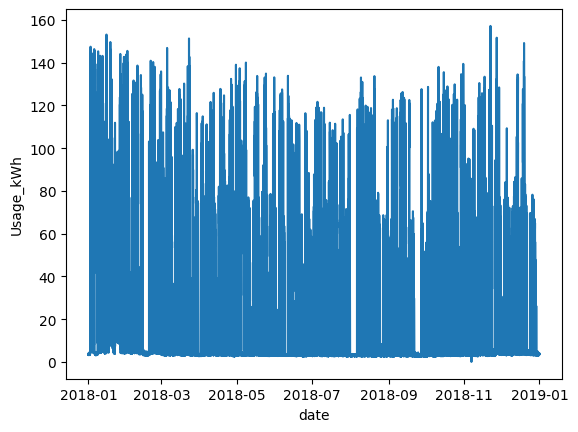

In [17]:
sns.lineplot(data=data,
             x='date',
             y='Usage_kWh')

<Axes: xlabel='date', ylabel='Usage_kWh'>

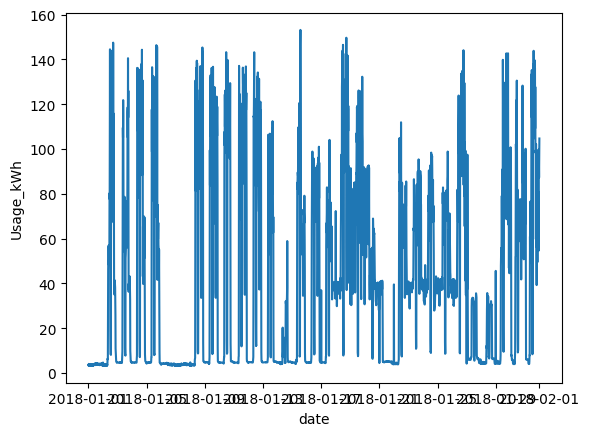

In [18]:
sns.lineplot(data=data.loc[(data.date >= '2018-01-01') &
                           (data.date <= '2018-02-01')],
             x='date',
             y='Usage_kWh')

<Axes: xlabel='date', ylabel='Usage_kWh'>

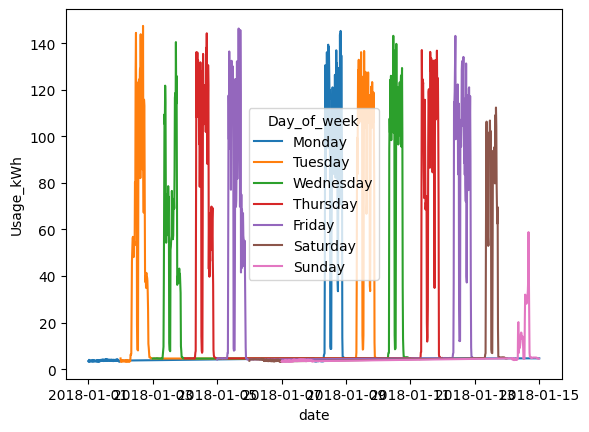

In [19]:
sns.lineplot(data=data.loc[(data.date >= '2018-01-01') &
                           (data.date <= '2018-01-15')],
             x='date',
             y='Usage_kWh',
             hue='Day_of_week')

<Axes: xlabel='Load_Type', ylabel='Usage_kWh'>

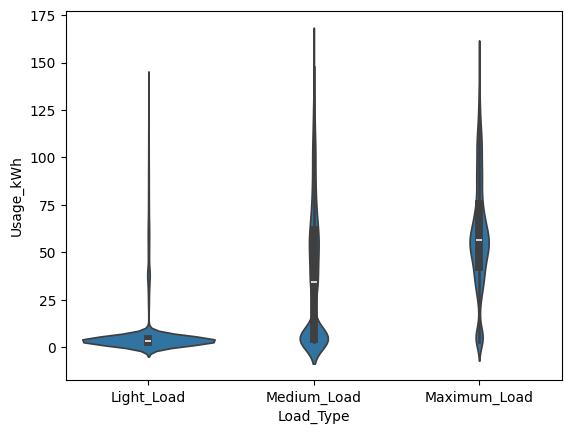

In [20]:
sns.violinplot(data=data,
            x='Load_Type',
            y='Usage_kWh')

<Axes: xlabel='hours', ylabel='Usage_kWh'>

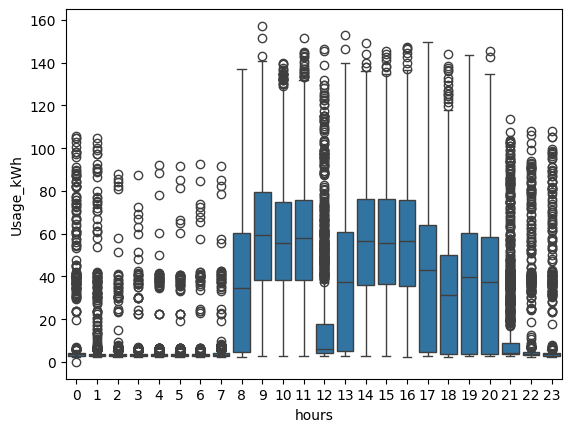

In [21]:
sns.boxplot(data=data,
            x='hours',
            y='Usage_kWh')

Podemos ver que hay cierta relación entre las horas de usos más altos y los picos de uso más pesados de usos de voltaje

# Data Separation

In [28]:
X_cols = [
        'Leading_Current_Reactive_Power_kVarh',
        'CO2(tCO2)',
        'Lagging_Current_Power_Factor',
        'Leading_Current_Power_Factor',
        'NSM',
        'Load_Type',
        'hours',
        'week_day_coded',
        'day_week_encoder',
        'loadtype_encoder']
y_cols = 'Usage_kWh'

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
X = data[X_cols]
y = data[y_cols]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [32]:
from pycaret.regression import *

In [35]:
s = RegressionExperiment()
s.setup(data, target=y_cols)

,Description,Value
0,Session id,2801
1,Target,Usage_kWh
2,Target type,Regression
3,Original data shape,"(35040, 15)"
4,Transformed data shape,"(35040, 25)"
5,Transformed train set shape,"(24528, 25)"
6,Transformed test set shape,"(10512, 25)"
7,Numeric features,10
8,Date features,1
9,Categorical features,3


In [36]:
best = s.compare_models()
best

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.4056,1.3946,1.1662,0.9988,0.0360,0.0152,2.3710
et,Extra Trees Regressor,0.4858,1.5216,1.2293,0.9986,0.0339,0.0168,1.8750
dt,Decision Tree Regressor,0.6114,2.5772,1.5934,0.9977,0.0477,0.0227,0.0900
lightgbm,Light Gradient Boosting Machine,0.8422,2.7666,1.6560,0.9975,0.0802,0.0619,0.2220
gbr,Gradient Boosting Regressor,1.7194,8.3865,2.8933,0.9925,0.1175,0.0980,0.5970
lr,Linear Regression,2.6185,22.0961,4.6649,0.9803,0.2212,0.1889,0.0660
br,Bayesian Ridge,2.6189,22.0961,4.6649,0.9803,0.2214,0.1890,0.0730
knn,K Neighbors Regressor,3.0345,39.9262,6.3089,0.9644,0.1478,0.1131,0.1510
ridge,Ridge Regression,5.0681,50.0768,7.0757,0.9553,0.5004,0.6255,0.0680
ada,AdaBoost Regressor,6.5823,53.0819,7.2450,0.9527,0.7728,1.3693,0.6090


Processing:   0%|          | 0/77 [00:00<?, ?it/s]

RandomForestRegressor(n_jobs=-1, random_state=2801)

In [37]:
s.evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

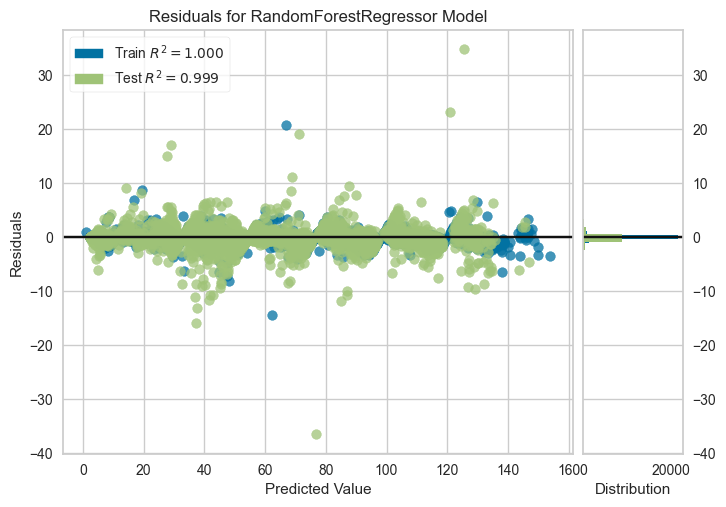

In [38]:
s.plot_model(best, plot='residuals')

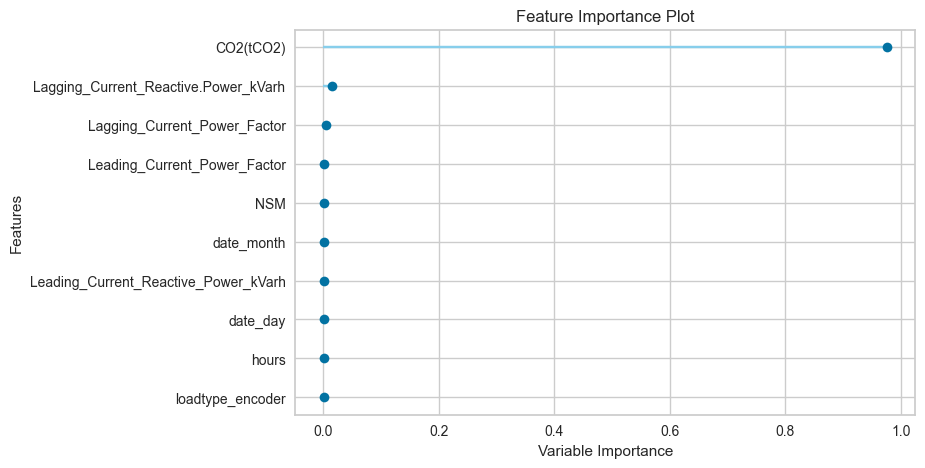

In [39]:

s.plot_model(best, plot = 'feature')

In [40]:

s.predict_model(best)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.4030,1.3882,1.1782,0.9988,0.0357,0.0153


,date,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,week_day_coded,day_week_encoder,loadtype_encoder,hours,Usage_kWh,prediction_label
2290,2018-01-24 20:45:00,0.680000,4.54,0.02,99.980003,99.260002,74700,Weekday,Wednesday,Medium_Load,0,2,1,20,37.009998,36.979701
1758,2018-01-19 07:45:00,39.889999,0.00,0.04,90.019997,100.000000,27900,Weekday,Friday,Light_Load,0,4,0,7,82.480003,82.288101
11367,2018-04-29 10:00:00,0.000000,23.18,0.00,100.000000,15.180000,36000,Weekend,Sunday,Light_Load,1,6,0,10,3.560000,3.646100
3832,2018-02-09 22:15:00,33.160000,0.00,0.04,94.040001,100.000000,80100,Weekday,Friday,Maximum_Load,0,4,2,22,91.660004,90.707300
1160,2018-01-13 02:15:00,4.000000,0.00,0.00,76.290001,100.000000,8100,Weekend,Saturday,Light_Load,1,5,0,2,4.720000,4.746400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12587,2018-05-12 03:00:00,3.960000,0.00,0.00,60.259998,100.000000,10800,Weekend,Saturday,Light_Load,1,5,0,3,2.990000,2.989300
1615,2018-01-17 20:00:00,0.500000,2.81,0.02,99.989998,99.730003,72000,Weekday,Wednesday,Maximum_Load,0,2,2,20,38.119999,38.812900
32884,2018-12-09 13:15:00,0.000000,13.57,0.00,100.000000,24.440001,47700,Weekend,Sunday,Light_Load,1,6,0,13,3.420000,3.429700
32794,2018-12-08 14:45:00,6.910000,0.00,0.02,98.360001,100.000000,53100,Weekend,Saturday,Medium_Load,1,5,1,14,37.730000,38.956900
